# Categorical Model Dedicated Notebook

## Data Admin:

15795
15795
15795
15795
(15795, 120, 160, 3)


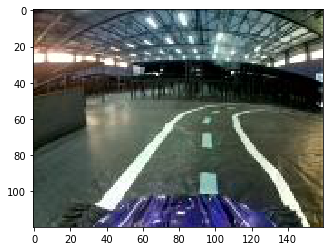

[0 0 1]


In [1]:
import os
import natsort
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'halldatarecords2/'

im_list = []

rec_list = []

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

        
print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.uint8)
for i in range(len(im_list)):
    filename = im_list[i]
    x_images[i,:,:,:] = cv2.imread(path+filename)
    
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
y_labels = np.zeros((len(rec_list),3), dtype=np.uint8) #setup label array for one-hot encoded left, right and straight
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        if orient > 0.05:
            y_labels[i] = [0,0,1] #right
            
        elif orient < -0.05:
            y_labels[i] = [1,0,0] #left
            
        else:
            y_labels[i] = [0,1,0] #straight
            
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
plt.imshow(x_images[1000])
plt.show()
print(y_labels[1000])

In [ ]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,120,160,3), dtype=np.uint8)
x_train = np.zeros((round(len(x_images)*0.7)+1,120,160,3), dtype=np.uint8)
y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.uint8)
y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.uint8)
n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
        
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[500])
plt.imshow(x_val[500])
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [3]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

model = Sequential()
model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.summary()

# Compile model:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\l

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 38, 32)        6944      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 18, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 11264)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1126500   
____

## Training and Validation:

In [ ]:
model.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 11057 samples, validate on 4739 samples
Epoch 1/20
11057/11057 [==============================] - 50s 5ms/sample - loss: 1.3104 - acc: 0.7655 - val_loss: 0.5809 - val_acc: 0.7575
Epoch 2/20
11057/11057 [==============================] - 47s 4ms/sample - loss: 0.2831 - acc: 0.8468 - val_loss: 0.5598 - val_acc: 0.7508
Epoch 3/20
11057/11057 [==============================] - 47s 4ms/sample - loss: 0.5469 - acc: 0.8346 - val_loss: 3.1066 - val_acc: 0.6723
Epoch 4/20
11057/11057 [==============================] - 49s 4ms/sample - loss: 12.6158 - acc: 0.7960 - val_loss: 160.5228 - val_acc: 0.5275
Epoch 5/20
11057/11057 [==============================] - 50s 5ms/sample - loss: 129.6343 - acc: 0.7499 - val_loss: 5.0361 - val_acc: 0.6852
Epoch 6/20
 5800/11057 [==============>...............] - ETA: 19s - loss: 488.6703 - acc: 0.7543

In [ ]:
out = model.predict(x_images, batch_size=200)

if out[1500,0] == 1:
    print('left')
elif out[1500, 1] == 1:
    print('straight')
elif out[1500, 2] == 1:
    print('right')
    
plt.imshow(x_images[1500])
plt.show()
print(out[1500])